# 3. Regression

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# from bayesian_linear_regressor import BayesianLinearRegression

## Regression intro

- What is regression
- Supervised learning

### Linear regression

- Linear model
- Common approaches
  - Least squares
  - Bayesian linear regression

### California housing dataset

The California housing dataset includes

In [2]:
housing_data = fetch_california_housing(as_frame=True)

df = housing_data['frame']
print(df.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


The housing data comprises of 8 features:

- `MedInc`: Median income of the population in the block.
- `HouseAge`: Average age of houses in the block.
- `AveRooms`: Average number of rooms in a house in the block.
- `AveBedrms`: Average number of bedrooms in a house in the block.
- `Population`: Population of the block.
- `AveOccup`: The average number of people living in a house.
- `Latitude`: Latitudinal position.
- `Logitude`: Longitudinal position.
- `MedHouseVal`: The median value of houses in the block.
 
The target feature is `MedHouseVal`.

We shall now look at the datatypes for each feature.

In [3]:
print(df.dtypes)

MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object


Each of the features are numerical, as is the target feature which makes regression easier.

### Geographical data

As the data is geographical it is a good idea to visualise it as such.

Using the `Latitude` and `Longitude` features we can plot the data as a scatter plot. Using the `alpha` parameter we can get an idea of population density across California.

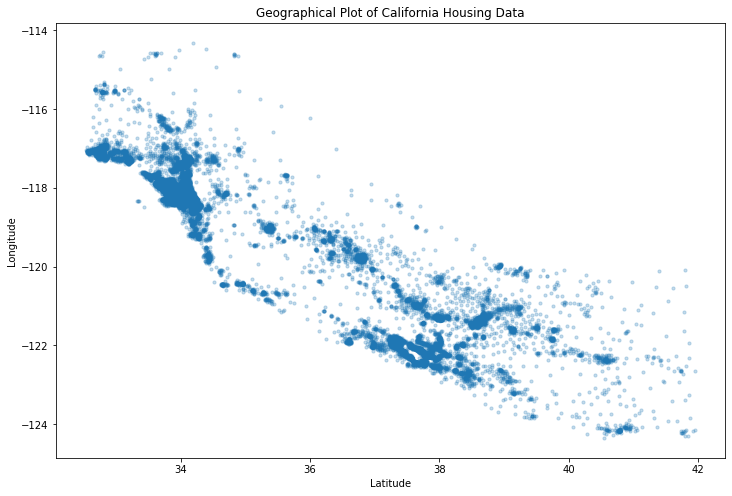

In [4]:
latitude = df['Latitude']
longitude = df['Longitude']

fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Geographical Plot of California Housing Data")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.scatter(latitude, longitude, s=10, alpha=0.25)
plt.show()

We can assume the whitespace in the lower left corner is due to no houses being located in the ocean. This means the high density points are along the coast, which may have a high correlation with house price.

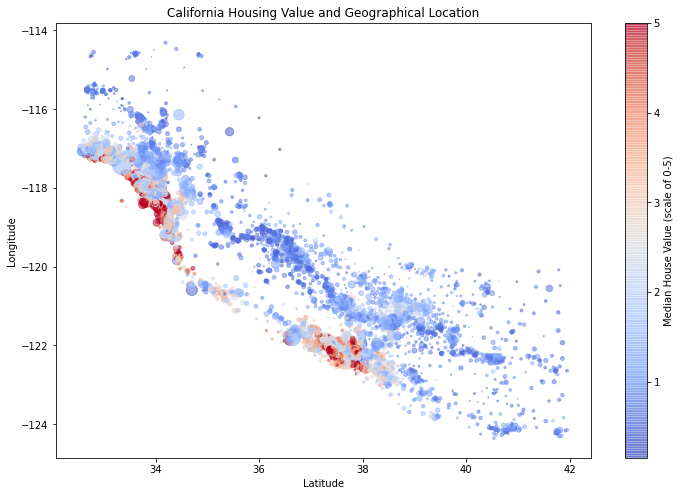

In [5]:
house_val = df['MedHouseVal']
population = df['Population']

fig, ax = plt.subplots(figsize=(12, 8))
plt.title("California Housing Value and Geographical Location")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.scatter(latitude, longitude, s=population/100, alpha=0.5, c=house_val, cmap='coolwarm')
plt.colorbar().set_label("Median House Value (scale of 0-5)")
plt.show()

From the scatter plot above we can see the more expensive (red) areas are closely packed, with the cheaper (blue) areas being far more scattered, as well as (generally) being further away from the coast. We can assume the more expensive areas relate to Los Angeles (north) and San Fransisco (south). We will need to ensure geographical data is encoded into the model as location evidetely has an impact on house price.

### Correlation and distribution

To get a quick look at the characteristics of the dataset we can use the `describe()` function.

In [6]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


From this we can see that some of the features have some large outlying values such as `AveRooms` and `AveOccup`, due to the max value being so much higher than the 75th percentile. We will have to handle this if we want to look at the histogram of the data as it may skew the results and not let us see the real distribution.

As we have already seen geographical data has a large impact on house value we will not explore its correlation with the other features any further. We will find the correlation between each of the remaining features.

In [7]:
non_geo = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
           'Population', 'AveOccup', 'MedHouseVal']

corr = df[non_geo].corr()
print(corr)

               MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc       1.000000 -0.119034  0.326895  -0.062040    0.004834  0.018766   
HouseAge    -0.119034  1.000000 -0.153277  -0.077747   -0.296244  0.013191   
AveRooms     0.326895 -0.153277  1.000000   0.847621   -0.072213 -0.004852   
AveBedrms   -0.062040 -0.077747  0.847621   1.000000   -0.066197 -0.006181   
Population   0.004834 -0.296244 -0.072213  -0.066197    1.000000  0.069863   
AveOccup     0.018766  0.013191 -0.004852  -0.006181    0.069863  1.000000   
MedHouseVal  0.688075  0.105623  0.151948  -0.046701   -0.024650 -0.023737   

             MedHouseVal  
MedInc          0.688075  
HouseAge        0.105623  
AveRooms        0.151948  
AveBedrms      -0.046701  
Population     -0.024650  
AveOccup       -0.023737  
MedHouseVal     1.000000  


We can see some inital results, such as income being highly correlated with house value but it will be easier to visualise as a correlation matrix.

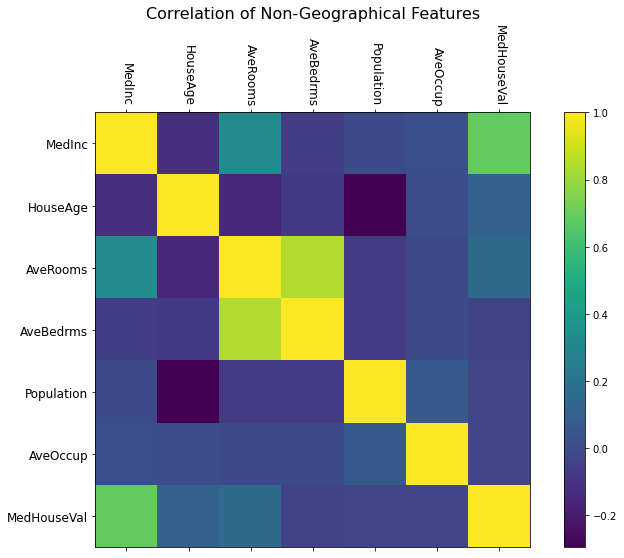

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Correlation of Non-Geographical Features", fontsize=16)
mat = ax.matshow(corr)
ax.set_xticks(range(len(non_geo)))
ax.set_yticks(range(len(non_geo)))
ax.set_xticklabels(non_geo, rotation=-90, fontsize=12)
ax.set_yticklabels(non_geo, fontsize=12)
plt.colorbar(mat, ax=ax)
plt.show()

We shall remove the highest values from some of the features with a long tail so we can get a better look at the disribution.

There are also some anomalies with the median house value and house age features. It seems that they have cut-offs of 5 and 50 repsectively and so there are a high number of them in the final bin on the histogram. This will have to be dealt with as to not skew the model.

In [9]:
df_nohigh = df.astype(float)
df_nohigh = df_nohigh.drop(df_nohigh[(df_nohigh['MedInc'] > 10) |
                                     (df_nohigh['HouseAge'] > 50) |
                                     (df_nohigh['AveRooms'] > 10) |
                                     (df_nohigh['AveBedrms'] > 2) |
                                     (df_nohigh['Population'] > 6000) |
                                     (df_nohigh['AveOccup'] > 8) |
                                     (df_nohigh['MedHouseVal'] > 4.7)].index)

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'MedHouseVal'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

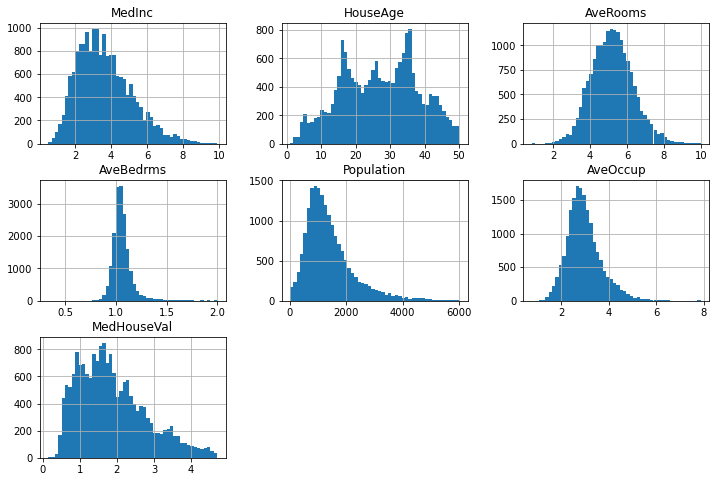

In [10]:
df_nohigh[non_geo].hist(bins=50, figsize=(12, 8))

It appears most features have a lognormal distribution - that is they rise sharply with a long right-hand tail. This is due to a a small number of blocks having abnormally large, high value homes.

Taking the log of these features should mean they are better fit by a normal distribution.

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'MedHouseVal'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

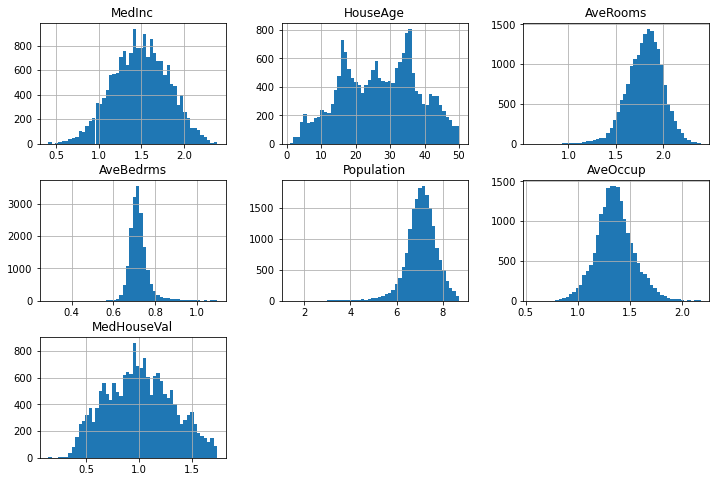

In [11]:
df_nohighnormal = df_nohigh.copy()
df_nohighnormal["MedInc"] = np.log1p(df_nohighnormal['MedInc'])
df_nohighnormal["AveRooms"] = np.log1p(df_nohighnormal['AveRooms'])
df_nohighnormal["AveBedrms"] = np.log1p(df_nohighnormal['AveBedrms'])
df_nohighnormal["Population"] = np.log1p(df_nohighnormal['Population'])
df_nohighnormal["AveOccup"] = np.log1p(df_nohighnormal['AveOccup'])
df_nohighnormal["MedHouseVal"] = np.log1p(df_nohighnormal['MedHouseVal'])

df_nohighnormal[non_geo].hist(bins=50, figsize=(12, 8))

We shall apply this to the full dataframe.

In [12]:
df_normal = df.copy()
df_normal["MedInc"] = np.log1p(df_normal['MedInc'])
df_normal["AveRooms"] = np.log1p(df_normal['AveRooms'])
df_normal["AveBedrms"] = np.log1p(df_normal['AveBedrms'])
df_normal["Population"] = np.log1p(df_normal['Population'])
df_normal["AveOccup"] = np.log1p(df_normal['AveOccup'])
df_normal["MedHouseVal"] = np.log1p(df_normal['MedHouseVal'])

### Missing data

Missing data will cause issues when it comes to training a model, so we will need to check for and deal with any missing data points.

In [13]:
df_normal.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

This seems to be a very clean dataset and does not have any missing values.

### Outliers

As with missing values, any outliers in the data could also cause our model to underperform.

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'MedHouseVal'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

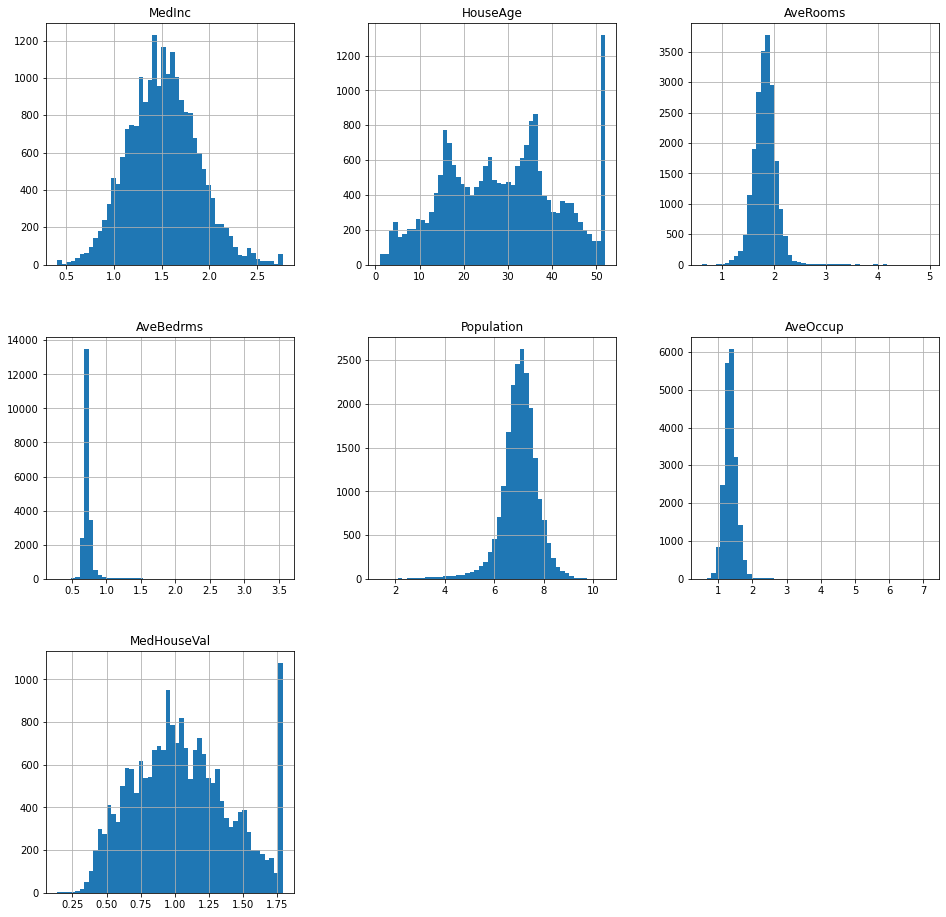

In [14]:
df_cut = df_normal.copy()
df_cut[non_geo].hist(bins=50, figsize=(16, 16))

It seems that the features `MedHouseVal` and `HouseAge` have been capped, this means there aren't any outliers but a large number of maximum values.

Had these values not been capped the data would have followed more of a lognormal distribution. That is the right-hand tail would have stretched out further slowly decreasing.

There is no way of recovering the lost data so instead we call cut off the cut-off. Later we shall scale the data so it should flatten out and be more normally distributed.

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>,
        <AxesSubplot:title={'center':'MedHouseVal'}>]], dtype=object)

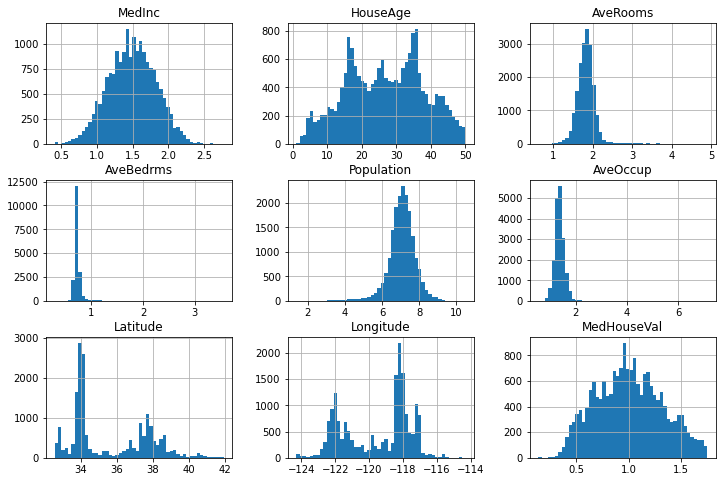

In [15]:
# df_nohigh = df[non_geo].astype(float)
df_cut = df_cut.drop(df_cut[(df_cut['HouseAge'] > 50) |
                            (df_cut['MedHouseVal'] > 1.75)].index)

df_cut.hist(bins=50, figsize=(12, 8))

### Feature engineering

It can be benificial to create additional features.

In [16]:
print(df_cut.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


In [17]:
extra_df = df_cut.copy()

extra_df['AveBedrmsPerRoom'] = extra_df['AveBedrms'] / extra_df['AveRooms']
extra_df['AveBedrmsPerOccup'] = extra_df['AveBedrms'] / extra_df['AveOccup']
extra_df['AveAddRooms'] = extra_df['AveRooms'] - extra_df['AveBedrms']
extra_df['EstHouses'] = extra_df['Population'] / extra_df['AveOccup']

new_features = ['MedHouseVal', 'AveBedrmsPerRoom', 'AveBedrmsPerOccup',
                'AveAddRooms', 'EstHouses']

new_features_corr = extra_df.corr()
new_features_corr['MedHouseVal'].abs().sort_values(ascending=False)

# fig, ax = plt.subplots(figsize=(12, 8))
# ax.set_title("Correlation of Non-Geographical Features", fontsize=16)
# mat = ax.matshow(new_features_corr)
# ax.set_xticks(range(len(new_features)))
# ax.set_yticks(range(len(new_features)))
# ax.set_xticklabels(new_features, rotation=-90, fontsize=12)
# ax.set_yticklabels(new_features, fontsize=12)
# plt.colorbar(mat, ax=ax)
# plt.show()

MedHouseVal          1.000000
MedInc               0.660354
AveAddRooms          0.261572
AveBedrmsPerRoom     0.250677
EstHouses            0.225882
AveOccup             0.201319
Latitude             0.200561
AveRooms             0.167882
AveBedrms            0.107306
Population           0.055287
AveBedrmsPerOccup    0.050447
Longitude            0.009847
HouseAge             0.002083
Name: MedHouseVal, dtype: float64

It seems the new bedrooms per room and additional rooms features are both better features than the individual bedroom and room features. We shall keep these and remove the original features. Estimated houses also seems to have added some good information so we shall keep it in the feature set.

The average bedrooms per person has not added any more information to the dataset so we shall remove this.

As for the geographical data we shall encode this later on.

#### Creating geographical features

As mentioned above, the geographical features `Latitude` and `Longitude` can be transformed into a single feature to represent distance to the closest city (LA and San Fransisco).

In [18]:
# LA location as north-westerly peak
la_lat, la_lon = 34, -118
# SF location as south-easterly peak
sf_lat, sf_lon = 38, -122

extra_df['DistToLA'] = np.sqrt((extra_df['Latitude'] - la_lat)**2 +
                               (extra_df['Longitude'] - la_lon)**2)
extra_df['DistToSF'] = np.sqrt((extra_df['Latitude'] - sf_lat)**2 +
                               (extra_df['Longitude'] - sf_lon)**2)

extra_df['DistToCity'] = extra_df[['DistToLA', 'DistToSF']].min(axis=1)

Now lets look at the correlation of this new feature with median house price.

In [19]:
city_corr = extra_df.corr()
city_corr['MedHouseVal'].abs().sort_values(ascending=False)

MedHouseVal          1.000000
MedInc               0.660354
DistToCity           0.433880
AveAddRooms          0.261572
AveBedrmsPerRoom     0.250677
EstHouses            0.225882
AveOccup             0.201319
Latitude             0.200561
AveRooms             0.167882
DistToLA             0.159078
AveBedrms            0.107306
Population           0.055287
AveBedrmsPerOccup    0.050447
DistToSF             0.026953
Longitude            0.009847
HouseAge             0.002083
Name: MedHouseVal, dtype: float64

This has created another great feature. As the distance to city feature is so much stronger than any other geographical feature we shall use this and drop the others.

We shall also check the distribution of this new feature.

<AxesSubplot:>

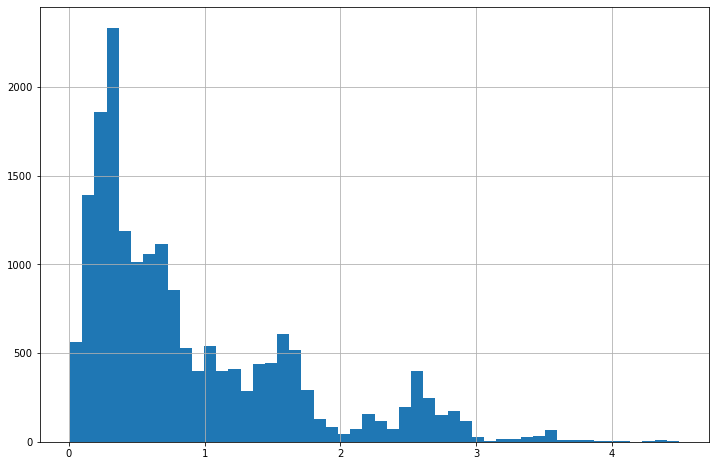

In [20]:
extra_df['DistToCity'].hist(bins=50, figsize=(12, 8))

This also looks like a log normal distribution, so lets take the log.

<AxesSubplot:>

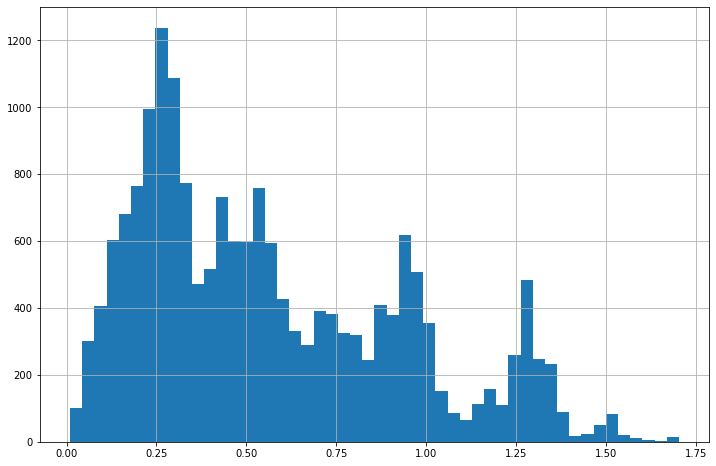

In [21]:
extra_df['DistToCity'] = np.log1p(extra_df['DistToCity'])
extra_df['DistToCity'].hist(bins=50, figsize=(12, 8))

This data is still highly skewed but we shall apply some scaling to help with this later.

### Categorical features

Categorical features in the data usually need to be encoded into numerical features for a machine learning algorithm to learn from them, especially with a regression model.

With this dataset there are only numerical features and all are of float type, so we can leave them as they are.

### Feature scaling

Now we have created all the features we shall used we shall apply scaling so features are centered with 0 mean.

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>,
        <AxesSubplot:title={'center':'AveBedrms'}>],
       [<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>,
        <AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>],
       [<AxesSubplot:title={'center':'MedHouseVal'}>,
        <AxesSubplot:title={'center':'AveBedrmsPerRoom'}>,
        <AxesSubplot:title={'center':'AveBedrmsPerOccup'}>,
        <AxesSubplot:title={'center':'AveAddRooms'}>],
       [<AxesSubplot:title={'center':'EstHouses'}>,
        <AxesSubplot:title={'center':'DistToLA'}>,
        <AxesSubplot:title={'center':'DistToSF'}>,
        <AxesSubplot:title={'center':'DistToCity'}>]], dtype=object)

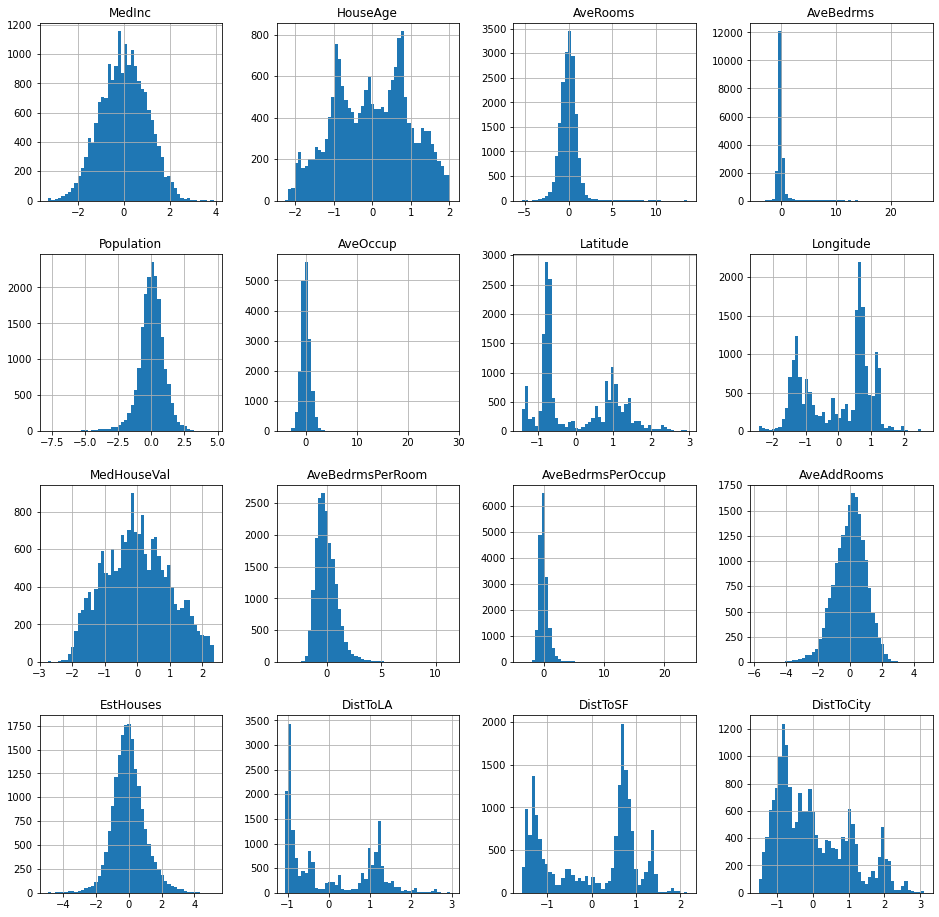

In [22]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(extra_df),
                         columns=extra_df.columns)

df_scaled.hist(figsize=(16, 16), bins=50)

### Feature Selection

As discussed in part one reducing the number of dimensions can also be benificial for both the training time and generalisation of the model. This can be done by removing unnescessary features, but also by combining similar features.

In [23]:
corr = extra_df.corr()
print(corr["MedHouseVal"].abs().sort_values(ascending=False))

MedHouseVal          1.000000
MedInc               0.660354
DistToCity           0.417095
AveAddRooms          0.261572
AveBedrmsPerRoom     0.250677
EstHouses            0.225882
AveOccup             0.201319
Latitude             0.200561
AveRooms             0.167882
DistToLA             0.159078
AveBedrms            0.107306
Population           0.055287
AveBedrmsPerOccup    0.050447
DistToSF             0.026953
Longitude            0.009847
HouseAge             0.002083
Name: MedHouseVal, dtype: float64


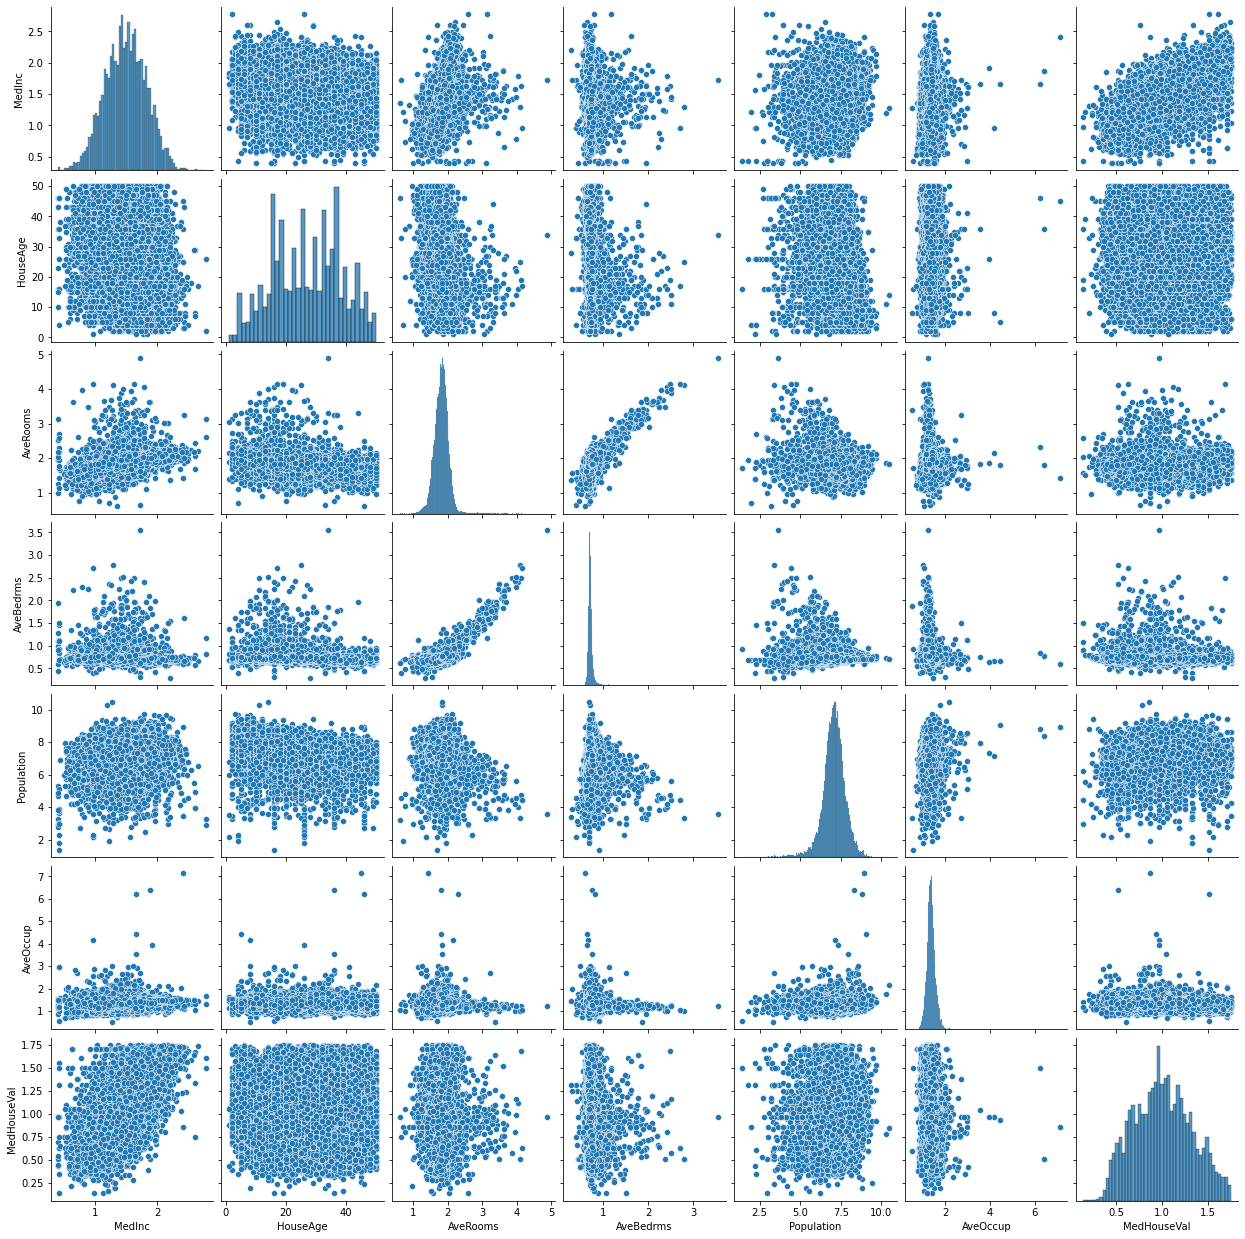

In [24]:
sns.pairplot(extra_df[non_geo])

We shall remove the bedroom and room features as the new bedrooms per room feature has better correlation.

As discussed earlier we shall remove all of the geographical features apart from `DistToCity`.

We shall also remove the bedrooms per person feature we created as it does not provide any more useful information.

The population and house age features also seem to have little correlation to house price also so we shall also remove those.

In [25]:
extra_df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal', 'AveBedrmsPerRoom',
       'AveBedrmsPerOccup', 'AveAddRooms', 'EstHouses', 'DistToLA', 'DistToSF',
       'DistToCity'],
      dtype='object')

In [26]:
features_to_remove = ['AveRooms', 'AveBedrms',
                      'Latitude', 'Longitude', 'DistToLA', 'DistToSF',
                      'AveBedrmsPerOccup', 'Population', 'HouseAge']

data = extra_df.drop(features_to_remove, axis=1, inplace=False)
data.head()

,MedInc,AveOccup,MedHouseVal,AveBedrmsPerRoom,AveAddRooms,EstHouses,DistToCity
0,2.232720,1.268511,1.709464,0.339349,1.372474,4.554671,0.230653
1,2.230165,1.134572,1.522790,0.343033,1.300376,6.860788,0.231721
8,1.125059,1.107536,1.183872,0.450202,0.916291,6.406919,0.266423
15,1.139434,1.292025,0.875469,0.439707,0.928284,5.068182,0.262492
18,1.095641,1.212765,0.950499,0.397957,1.112249,5.688420,0.266423


We now have the most correlating features, whilst not duplicating any information between them.

We have also reduced the dimensionality of the data which should aid both model training ease and generalisation.

### Notes on sampling

- In group bias
- Ground truth
- Prior belief
- Sampling bias
- Selection bias
- Bias variance trade-off

## Bayesian Linear Regression

#### Bayes Theorem

- Bayes theorem
- Bayes rule
- Bayesian statistics

#### MCMC

- Markov chain
- Markov property
- MCMC
- Metropolis Hastings

#### Bayesian linear regression

- What is bayesian linear regression

#### Prior beliefs

- Prior for Bayesian
- Log-normal distribution

#### Prepare data for model

- Test train val split
- Scaling

In [27]:
print(data.columns)

Index(['MedInc', 'AveOccup', 'MedHouseVal', 'AveBedrmsPerRoom', 'AveAddRooms',
       'EstHouses', 'DistToCity'],
      dtype='object')


#### Spilt features and labels

Seperate features and labels and create new dataframes.

In [28]:
X_features = ['MedInc', 'AveOccup', 'AveBedrmsPerRoom',
              'AveAddRooms', 'EstHouses', 'DistToCity']
y_features = ['MedHouseVal']

X = data[X_features]
y = data[y_features]

#### Get test and train sets

Create testing and training sets. Combine features and labels into train and test data frames.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
data_train = pd.concat((y_train, X_train), axis=1)
data_test = pd.concat((y_test, X_test), axis=1)

#### Pipeline

- Create pipeline

#### Performance measure

- Define the performance measure of the model.
- MSE / RMSE

#### Create the model

Create initial Bayesian linear regression model with guassian priors.

In [31]:
# def normal_linreg(data, formula):
#     with pm.Model() as model:
#         # Normal prior
#         family = pm.glm.families.Normal()
#         # Create model from formula
#         pm.GLM.from_formula(formula, data=data, family=family)
#         return model

#### Model sampler

Method to sample model and return trace.

In [32]:
# def sample_model(n_samples=1000, n_tune=500, n_cores=2):
#     trace = pm.sample(draws=n_samples, tune=n_tune,
#                       progressbar=True, cores=n_cores)
#     return trace

### Sample the model

In [33]:
# formula = "MedHouseVal ~ MedInc + AveOccup + AveBedrmsPerRoom +\
#            AveAddRooms + EstHouses + DistToCity"

# with normal_linreg(data_train, formula):
#     normal_linreg_trace = sample_model(n_samples=5000, n_tune=500,
#                                        n_cores=16)

In [34]:
# pm.save_trace(normal_linreg_trace, directory="traces", overwrite=True)

#### Evaluation of model

- Evaluate model performance on val / test set

#### Analyse the sample trace

In [35]:
# pm.traceplot(normal_linreg_trace)

In [36]:
# pm.plot_posterior(normal_linreg_trace)

In [37]:
# pm.forestplot(normal_linreg_trace)

#### Test the model

In [38]:
# # calculate mae and rmse for model on X, y
# def score(trace, X, y):
#     # get mean of coefficients
#     all_coeffs = np.asarray([trace[name] for name in trace.varnames])
#     coeff_means = all_coeffs.mean(axis=1)
#     # set intercept and variable coefficients
#     n_coeffs = X.shape[1]
#     coeffs = coeff_means[:n_coeffs+1]
#     # get predictions
#     X = np.column_stack((np.ones((X.shape[0])), X))
#     preds = np.dot(coeffs, X.T)
#     # calculate mae, rmse
#     labels = np.asarray(y).reshape(-1)
#     errors = preds - labels
#     mae = np.mean(abs(errors))
#     rmse = np.sqrt(np.mean(errors**2))
#     return (mae, rmse)

In [39]:
# mae, rmse = score(normal_linreg_trace, X_test, y_test)

# print("Bayesian Linear Regression Mean Results")
# print(f"Mean absolute error     (MAE)  : {mae:.3f}")
# print(f"Root mean squared error (RMSE) : {rmse:.3f}")

### Compare to standard linear regression

In [40]:
# linreg = LinearRegression()
# linreg.fit(X_train, y_train)

In [41]:
# linreg_preds = linreg.predict(X_test)
# linreg_mae = mean_squared_error(y_test, linreg_preds)
# print(linreg_mae)

### Scikit-learn wrapper

I have created a scikit-learn wrapper class for the model above which gives the model sklearn functionality.

Create an instance of `BayesianLinearRegression`:

In [44]:
from bayesian_linear_regressor import BayesianLinearRegression

bayesianreg = BayesianLinearRegression()

Call `fit()` with the training features `X` and real values `y` with the model formula create and sample from the model.

Additional parameters `n_samples`, `n_tune` and `n_cores` are available.

In [45]:
bayesianreg.fit(X_train, y_train, n_samples=5000, n_tune=1000, n_cores=16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sd, DistToCity, EstHouses, AveAddRooms, AveBedrmsPerRoom, AveOccup, MedInc, Intercept]
Sampling 16 chains, 0 divergences:   1%|▏         | 1371/96000 [00:01<01:47, 876.48draws/s] 


ValueError: Not enough samples to build a trace.

This will also instanciate the objects model and trace attributes:`bayesianreg.model_` and RMSE: `bayesianreg.trace_`.

Call `predict` with test features `X` to return predicted values.

This will also instanciate the objects mean coefficients attribute:`bayesianreg.mean_coeffs_`.

Call `score()` with test features `X` and real values `y` to return the RMSE of the model on the training data.

This will also instanciate the objects attributes for MAE:`bayesianreg.mae_` and RMSE: `bayesianreg.rmse_`.

Adding this functionality will allow use to use ensemble methods with other scikit-learn models using the `StackingRegressor`.

#### Bayesian linear regression optimisation

- Ridge / lasso regression

### Regression conclusion

- Concluding points on things learnt from dataset.
- Concluding points of Bayesian regression performance.